In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
import shap

In [57]:
x = pd.read_csv("../data/merged_data.csv")
x.drop(x.columns[0], axis=1, inplace=True)
x.head()

,voiv,pov,mun,mun_type,msegm,mwg7,mwg7d,ctype,area_km2,bld_t,...,pod_enc,pod_gst,pod_trt,pod_trst,pod_tsto,pod_ps,pod_hea,pod_heap,lat,lon
0,POMORSKIE,GDYNIA,GDYNIA,GMINA MIEJSKA,A1,2262011,2262011,MIASTO,0.4461,535,...,40,876,25,885,25,346,74,83,54.522473,18.543697
1,ŚLĄSKIE,GLIWICE,GLIWICE,GMINA MIEJSKA,A1,2466011,2466011,MIASTO,0.1666,65,...,63,510,65,2174,454,1109,40,40,50.281363,18.670286
2,KUJAWSKO-POMORSKIE,BYDGOSZCZ,BYDGOSZCZ,GMINA MIEJSKA,A1,461011,461011,MIASTO,0.2248,66,...,15,441,264,1304,264,1022,15,15,53.157879,18.162657
3,MAŁOPOLSKIE,BRZESKI,BRZESKO,CZĘŚĆ MIEJSKA GMINY MIEJSKO-WIEJSKIEJ,B3,1202024,1202024,MIASTO,0.1834,49,...,322,43,1055,2733,1055,773,187,187,49.962999,20.598595
4,DOLNOŚLĄSKIE,WROCŁAW,WROCŁAW-FABRYCZNA,DZIELNICA MIASTA,A1,264011,264029,MIASTO,0.1242,52,...,680,634,63,1528,63,2389,190,268,51.122731,16.974460


In [58]:
categorical_col = x.select_dtypes(include=["object"]).columns.tolist()

In [59]:
categorical_col

['voiv', 'pov', 'mun', 'mun_type', 'msegm', 'ctype']

In [60]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_col])

In [61]:
one_hot_df = pd.DataFrame(one_hot_encoded,columns=encoder.get_feature_names_out(categorical_col))
one_hot_df.head()

,voiv_DOLNOŚLĄSKIE,voiv_KUJAWSKO-POMORSKIE,voiv_LUBELSKIE,voiv_LUBUSKIE,voiv_MAZOWIECKIE,voiv_MAŁOPOLSKIE,voiv_OPOLSKIE,voiv_PODKARPACKIE,voiv_PODLASKIE,voiv_POMORSKIE,...,mun_type_GMINA WIEJSKA,msegm_A1,msegm_A2,msegm_B1,msegm_B2,msegm_B3,msegm_C1,msegm_C2,ctype_MIASTO,ctype_WIEŚ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


too many catecorical cols

In [62]:
categorical_col.remove("ctype")

In [63]:
x = pd.get_dummies(x, columns=["ctype"], dtype=float)
x.drop(columns=categorical_col, inplace=True)

In [64]:
y = pd.read_csv("../src/sales.csv")
y.drop(y.columns[0], axis=1, inplace=True)
y.rename(columns={"0": "sales"}, inplace=True)
y.head()

,sales
0,1.005890e+08
1,2.771304e+06
2,1.133997e+07
3,3.188996e+05
4,2.953807e+06


In [79]:
x= x.fillna(x.mean())
y = y.fillna(y.mean())

In [80]:
x_background_dist = x[:100]
x = x[100:]
y = y[100:]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x, y.values, test_size=0.2, random_state=0)

In [82]:
np.mean(y_test), np.std(y_test)

(np.float64(6153189.493206211), np.float64(10970414.656643888))

In [83]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
np.sqrt(np.mean((lin_regr.predict(X_test) - y_test) ** 2))

np.float64(3102203.0096571664)

In [84]:
explainer = shap.Explainer(lin_regr.predict, x_background_dist)
shap_values = explainer(X_test) 

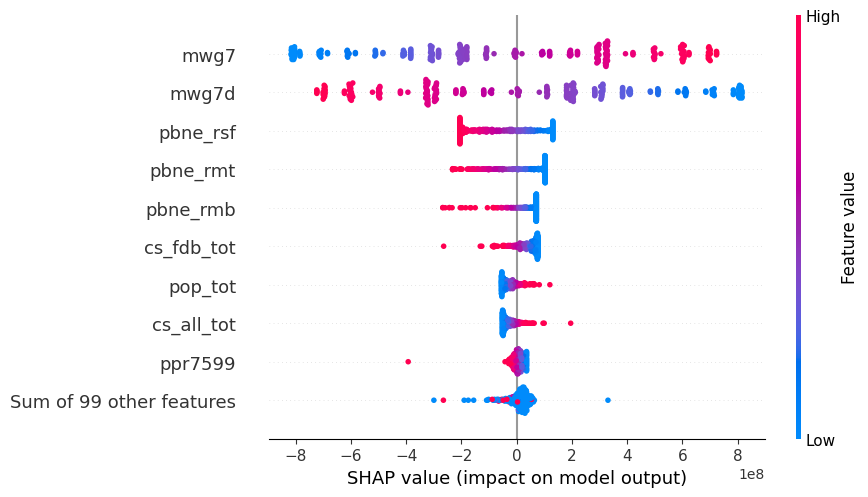

In [85]:
shap.plots.beeswarm(shap_values)

In [87]:
mean_shape_values = shap_values.mean(0).values
feature_importance_by_shapley = dict((zip(X_test.columns, mean_shape_values)))

In [88]:
sum_of_coefs = sum((feature_importance_by_shapley.values()))

In [89]:
for feature in feature_importance_by_shapley:
    feature_importance_by_shapley[feature] = feature_importance_by_shapley[feature] / sum_of_coefs

In [90]:
feature_importance_by_shapley

{'mwg7': np.float64(4.246567982358648),
 'mwg7d': np.float64(-4.245427645455424),
 'area_km2': np.float64(-0.35423268748797687),
 'bld_t': np.float64(0.1688014431016437),
 'bld_r': np.float64(-0.010440179641863964),
 'apts_t': np.float64(0.642479079485822),
 'apts_r': np.float64(-0.2651423082041513),
 'pop_apts': np.float64(0.6750091289286804),
 'pop_tot': np.float64(2.6522425553704942),
 'hh_size': np.float64(-0.0076554510041056244),
 'pop_den': np.float64(-0.7183858413351047),
 'pop_ax_t': np.float64(0.22313317933882326),
 'pprf': np.float64(0.1886163596180993),
 'pprm': np.float64(-0.07847112680196283),
 'ppr0004': np.float64(-0.09164946581734804),
 'ppr0509': np.float64(0.020476774773875626),
 'ppr1014': np.float64(0.008139495991730562),
 'ppr1519': np.float64(-0.004641718671598632),
 'ppr2024': np.float64(0.05496408835955416),
 'ppr2529': np.float64(0.08536965591690764),
 'ppr3034': np.float64(0.13628481540739806),
 'ppr3539': np.float64(0.058374776893216865),
 'ppr4044': np.float

In [91]:
dataset = x.join(y)
corr = dataset.corr()

<Axes: >

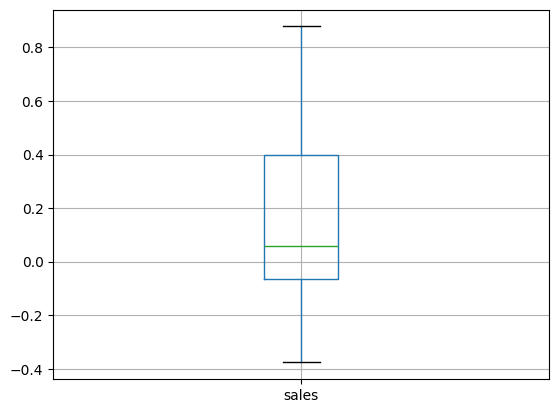

In [92]:
corr[["sales"]][:-1].boxplot()

In [93]:
import json

with open ("../data/ficzurs_koefiszietns.json", "w") as fp:
    json.dump(feature_importance_by_shapley, fp, ensure_ascii=False, indent=4)

In [94]:
y_train[:,0].shape

(1051,)

In [97]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=5)
rf.fit(X_train, y_train[:,0])
np.sqrt(np.mean((rf.predict(X_test) - y_test) ** 2))

np.float64(16811152.158205934)

In [96]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 64), learning_rate_init=0.01)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

np.float64(14605312.599477986)

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(), max_iter=1000, activation="identity", learning_rate_init=0.01)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(32,), max_iter=1000, activation="relu", learning_rate_init=0.001)
mlp.fit(X_train, y_train[:,0])
np.sqrt(np.mean((mlp.predict(X_test) - y_test) ** 2))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_x.fit(X_train, y_test)
x_train_scaled = scaler_x.transform(X_train)
x_test_scaled = scaler_x.transform(X_test)



mlp = MLPRegressor(hidden_layer_sizes=(), max_iter=10000, activation="identity", learning_rate_init=0.1)
mlp.fit(x_train_scaled, y_train[:,0])
np.sqrt(np.mean((mlp.predict(x_test_scaled) - y_test) ** 2))